# Apache Spark Structured Streaming and Tensorflow 2 integration

## Start Spark

In [1]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, LongType, BinaryType
from pyspark.sql.functions import pandas_udf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

from PIL import Image
from matplotlib.pyplot import imshow

from typing import Iterator, Tuple
import numpy as np
import pandas as pd
import io
import os

In [2]:
# Start a Spark session manually
findspark.init()
spark = SparkSession \
    .builder \
    .appName("Python") \
    .master("local[*]") \
    .getOrCreate()

spark

## Settings

In [3]:
model_file = "./model"
img_dir = "./img"

## Train a small Tensorflow 2 model on the MNIST dataset

Copyright 2019 The TensorFlow Authors.

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [5]:
# Get some test data for trainng
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("The train data has shape {}".format(x_train.shape))
print("The test data has shape {}".format(x_test.shape))

The train data has shape (60000, 28, 28)
The test data has shape (10000, 28, 28)


In [6]:
# Define a small Tensorflow model
def get_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10)
    ])

In [7]:
# Train and save the model
model = get_model()
model.summary()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss_fn, metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
model.save(model_file)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2994 - accuracy: 0.9126
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1446 - accuracy: 0.9570
Epoch 3/5
1875/1875 [=========================

In [8]:
# Load the model and report some metrices
new_model = load_model(model_file)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [9]:
predictions = np.argmax(new_model.predict(x_test), axis=1)
accuracy = np.mean(predictions == y_test)
print(f"The accuracy on the test data is {accuracy:.4f}")

The accuracy on the test data is 0.9778


## Define a Spark structured stream deom file using the TF model

In [14]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, LongType, BinaryType
from typing import Iterator, Tuple
from pyspark.sql.functions import pandas_udf
import pandas as pd
import io

In [18]:
# Extract label from path
@pandas_udf("string")
def extract_label(iterator: Iterator[pd.Series]) -> Iterator[pd.Series]:
    for paths in iterator:
        labels = [path[-5] for idx, path in paths.iteritems()]
        yield pd.Series(labels)

# Get the image data from the bytebuffer as read by Spark
def decode_image(data):
    return np.array(Image.open(io.BytesIO(data)))

# Predict the label of an image given a model
def predict_label(model, image_data):
    data = decode_image(image_data)
    data = np.expand_dims(data, 0)/255.0
    prediction = np.argmax(model(data).numpy())
    return str(prediction)

# Embed the TF model in an UDF
@pandas_udf("string")
def image_rec(iterator: Iterator[pd.Series]) -> Iterator[pd.Series]:
    model = load_model(model_file)
    for content in iterator:
        predictions = [predict_label(model, image_data) for idx, image_data in content.iteritems()]
        yield pd.Series(predictions)
    
# Define the input stream
input_schema = StructType([
  StructField("path", StringType(), False),
  StructField("modificationTime", TimestampType(), False),
  StructField("length", LongType(), False),
  StructField("content", BinaryType(), True)
])
    
img_stream = (spark
              .readStream
              .schema(input_schema)
              .format("binaryFile")
              .load("./img"))

# Define the query with the TF model
query = (img_stream
    .select(extract_label("path"), image_rec("content"))
    .withColumnRenamed('extract_label(path)', 'label')
    .withColumnRenamed('image_rec(content)', 'prediction'))

# Define the output location
output = (query
          .writeStream
          .outputMode("append")
          .option("checkpointLocation", "./checkpoint")
          .format("console")
          .start())

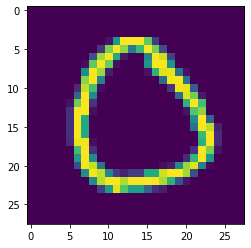

In [17]:
# Export some test images to the drop dir and show an example image
os.makedirs(img_dir, exist_ok = True) 
for i in range(10):
    image_data =  (255 * np.squeeze(x_test[1000 + i])).astype(np.uint8)
    label = y_test[1000 + i]
    img = Image.fromarray(image_data, 'L') # L is the greyscale mode
    img.save("{}/img{}-lbl{}.jpg".format(img_dir, i, label))
    
imshow(image_data)

```-------------------------------------------
Batch: 0
-------------------------------------------
+-----+----------+
|label|prediction|
+-----+----------+
|    5|         5|
|    0|         0|
|    2|         2|
|    7|         7|
|    9|         9|
|    0|         0|
|    1|         1|
+-----+----------+
```

### Stop any active stream with this command

In [15]:
for stream in spark.streams.active:
    if stream.isActive: stream.stop()

## FIN
    